<a href="https://colab.research.google.com/github/AnkitPatel745/Retail-Sales-Prediction-Capstone_Project/blob/main/Rossmann_Sales_Prediction_Capstone_Project(ML_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [22]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Importing Warnings To Ignore the Warning
import warnings
from warnings import filterwarnings
filterwarnings('ignore')





In [23]:
# Importing the dataset
dataset = pd.read_csv("/content/drive/MyDrive/Datasets/Rossmann Stores Data.csv")
dataset1 = pd.read_csv("/content/drive/MyDrive/Datasets/store.csv")

In [24]:
# First Look
dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [25]:
# Checking Size Of Data Set
dataset.shape

(1017209, 9)

In [26]:
# checking the length of the column
len(dataset)

1017209

In [27]:
# First Look
dataset1.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [28]:
# Checking Size OF dataset1
dataset1.shape

(1115, 10)

In [29]:
# checking the length of the column
len(dataset1)

1115

In [30]:
# Merging both the dataset on store columnn because it present on both the dataset
df = pd.merge(dataset,dataset1, on = 'Store', how='left' )

In [31]:
# First Look
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [32]:
# Size Of The Data set after Merging
df.shape

(1017209, 18)

In [33]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [46]:
df.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1017209,1017209,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,2015-01-18,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01,NaN,NaN,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01,NaN,NaN,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,NaN
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,NaN
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00,NaN,NaN,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,NaN


In [34]:
# Missing Value Count Function
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(df[show_missing()].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

Missing Data Count
PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
PromoInterval                49.94
Promo2SinceYear              49.94
Promo2SinceWeek              49.94
CompetitionOpenSinceYear     31.79
CompetitionOpenSinceMonth    31.79
CompetitionDistance           0.26
dtype: float64


In [35]:
# Removing Duplicate Values From The Data Set
df.drop_duplicates()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [38]:
# Functions used in this project for outlier determination (Not to Plot The Same Thing Again and Again)
""" Visualize the Numerical Features """
def visualize_num_feature(df):
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    sns.boxplot(df)
    plt.subplot(1,2,2)
    sns.distplot(df, bins=20)
    plt.show()
 
""" Use IQR rule to identify potential outliers"""
def stat_summary(df):
    stat =  df.describe()
    print(stat)
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5 * IQR
    lower = stat['25%'] - 1.5 * IQR
    print('The upper and lower bounds for suspected outliers are {} and {}' .format(upper, lower))

Visulaize lead_time Feature


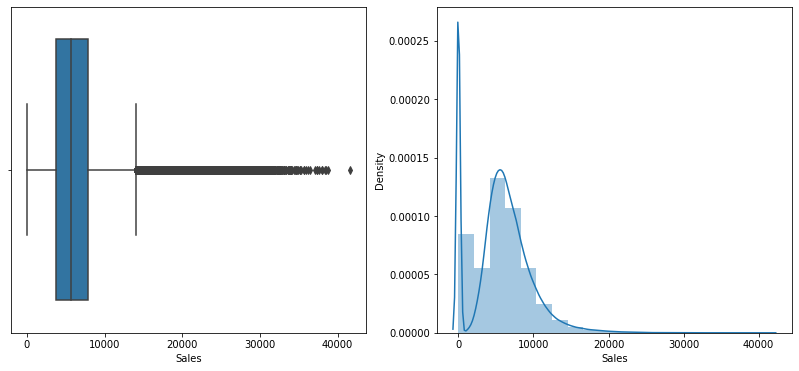

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64
The upper and lower bounds for suspected outliers are 14049.5 and -2466.5


In [42]:
# plotting the boxplot for finding the Outlier in the sales feature of the Dataset
### Sales
print('Visulaize Sales Feature')
visualize_num_feature(df.Sales)
stat_summary(df.Sales)

Visulaize Sales Feature


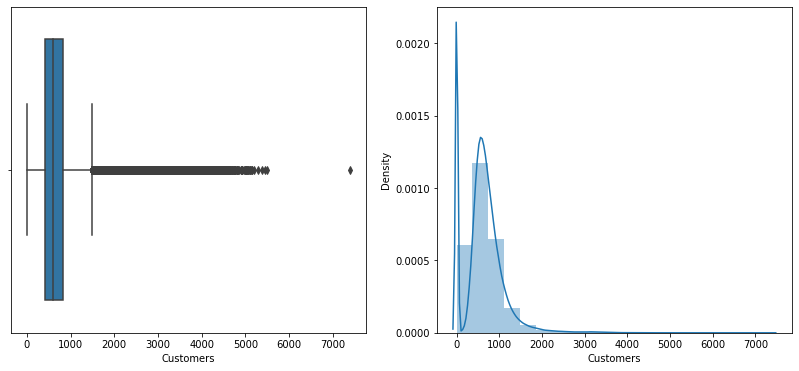

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64
The upper and lower bounds for suspected outliers are 1485.0 and -243.0


In [43]:
# plotting the boxplot and Density for finding the Outlier in the Customers feature of the Dataset
### Customers
print('Visulaize Customers Feature')
visualize_num_feature(df.Customers)
stat_summary(df.Customers)

Visulaize Open Feature


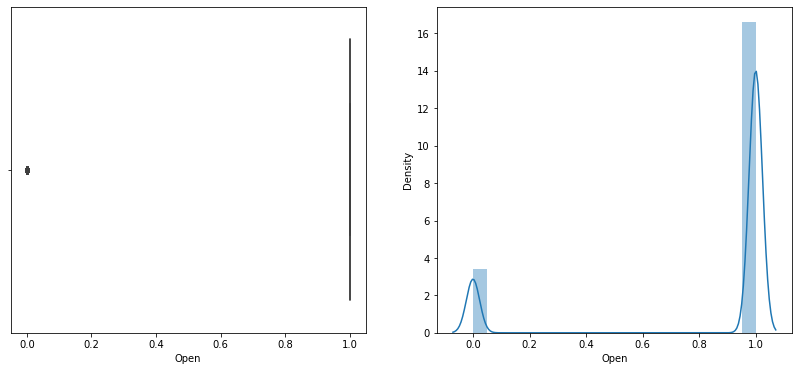

count    1.017209e+06
mean     8.301067e-01
std      3.755392e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Open, dtype: float64
The upper and lower bounds for suspected outliers are 1.0 and 1.0


In [47]:
# plotting the boxplot and Density for finding the Outlier in the Open feature of the Dataset
### Open
print('Visulaize Open Feature')
visualize_num_feature(df.Open)
stat_summary(df.Open)

Visulaize Open Feature


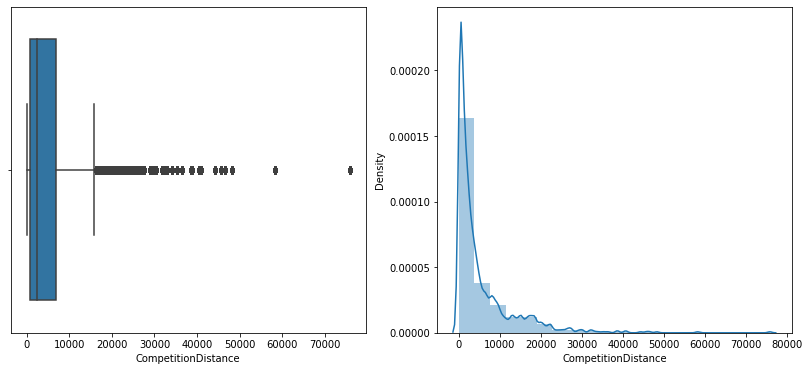

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64
The upper and lower bounds for suspected outliers are 16160.0 and -8560.0


In [48]:
# plotting the boxplot and Density for finding the Outlier in the CompetitionDistance Dataset
### CompetitionDistance
print('Visulaize CompetitionDistance Feature')
visualize_num_feature(df.CompetitionDistance)
stat_summary(df.CompetitionDistance)

Visulaize CompetitionOpenSinceMonth Feature


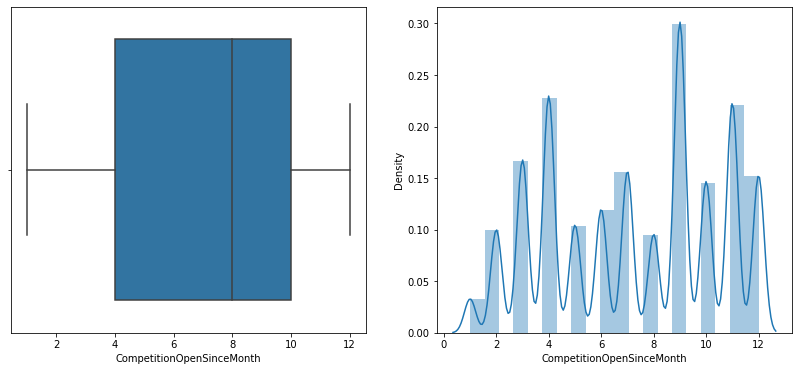

count    693861.000000
mean          7.222866
std           3.211832
min           1.000000
25%           4.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: CompetitionOpenSinceMonth, dtype: float64
The upper and lower bounds for suspected outliers are 19.0 and -5.0


In [49]:
# plotting the boxplot and Density for finding the Outlier in the CompetitionDistance Dataset
### CompetitionDistance
print('Visulaize CompetitionOpenSinceMonth Feature')
visualize_num_feature(df.CompetitionOpenSinceMonth)
stat_summary(df.CompetitionOpenSinceMonth)